:warning:**IMPORTANT NOTICE**:warning:\
*Since the initial parameterisation and gradient descent optimisation are stochastic processes, the training of a neural network is not fully reproducible.*

*Therefore, it is not recommended to re-run this script as it will overwrite the original calibration of the neural network used in the work presented here.
The purpose of this script is solely to document the training procedure and can be copied as a template to fit other new neural networks.*

*To experiment with the models calibrated here, they can be loaded from the `saved_models` directory.*

# Explore: Baseline ANN-thermobarometer using transfer learning

Train with natural data, but use pre-trained weights from a model trained on synthetic data.

### Initial hyperparameter
**Performance metrics:**
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
    - RMSE inverse transformed for pressure and temperature

**Last layer activation function:**
- Linear --> Regression problem

**Loss function:**
- Mean Squared Error (MSE)

**Optimizer:**
- Adam

### Goal
Following the chapter of Toorey and Shavlik in Olivas et al. (2009) "Machine Learning Applications and Trends" the following criteria are used to asses the effectiveness of transfer learning:
- Lower startibg point for the learning curve (in loss, RMSE T or RMSE P)
- Faster convergence, maning steeper slope of the learning curve
- Lower asymptotic error, meaning lower RMSE T and RMSE P

As a reference the best-performing model fitted directly on the natural data is used.\
- RMSE T $\approx$ $\pm$ 20°C
- RMSE P $\approx$ $\pm$ 450-600 bar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from keras.models import Sequential, load_model
from keras.layers import Dense, Normalization, BatchNormalization, LayerNormalization, Dropout
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, schedules
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.callbacks import CSVLogger, EarlyStopping
from sklearn.model_selection import train_test_split

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import rootmeansquarerror_temperature_denormalised, rootmeansquarerror_pressure_denormalised
from ml_tb.plot import plot_training_curve, prediction_vs_truth

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_20484\2381737759.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import data, pre-procesing and train/test split

Validation set is **20%** of the training set. Approx. 200 samples.

In [2]:
VALIDATION_FRACTION = 0.2

Global scaling parameters for MinMaxScaling of the target data are hard-coded to the range of the training data.

In [3]:
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

**IMPORTANT:** Reorder the elements in the natural data to match the order of the synthetic data!\
--> Mn and Mg are swapped in the natural data compared to the synthetic data.

In [4]:
# load excel file
data = pd.read_excel(Path("..","01_fit_natural_biotite","Metapelite-Database_Bt_CLEAN_2024-02-03.xlsx"))

biotite_composition = np.zeros(shape=(len(data), 6))
biotite_composition[:, 0] = data["Bt-Si"]
biotite_composition[:, 1] = data["Bt-Ti"]
biotite_composition[:, 2] = data["Bt-Al"]
biotite_composition[:, 3] = data["Bt-FeTot"]
biotite_composition[:, 4] = data["Bt-Mg"]
biotite_composition[:, 5] = data["Bt-Mn"]

pt = np.zeros(shape=(len(data), 2))
pt[:, 0] = data["Pressure estimate random uniform"] * 1000 # convert to bar
pt[:, 1] = data["Temperature random ordered after Ti-in-Bt"]

# check for NaN values (should be already filtered out)
print("NaN values in biotite composition: ", np.isnan(biotite_composition).any())
print("NaN values in PT: ", np.isnan(pt).any())

NaN values in biotite composition:  False
NaN values in PT:  False


In [5]:
# test train split
data_train, data_val, pt_train, pt_val = train_test_split(biotite_composition, pt, test_size=VALIDATION_FRACTION, shuffle=True)

# NORMALISATION
normalisation_biotite_composition = Normalization(axis=-1)
normalisation_biotite_composition.adapt(data_train)

print(normalisation_biotite_composition.mean.numpy())
print(np.sqrt(normalisation_biotite_composition.variance.numpy()))

# SCALING of PT
pt_train_norm = scaling_pt(pt_train)
pt_val_norm = scaling_pt(pt_val)

print("After scaling, the minimal values of P and T are: ", np.min(pt_train_norm, axis=0))
print("After scaling, the maximal values of P and T are: ", np.max(pt_train_norm, axis=0))

[[2.707096   0.12094202 1.7113718  1.2331702  1.0860624  0.00846446]]
[[0.04718959 0.04792102 0.09338911 0.2307204  0.26274422 0.00744217]]
After scaling, the minimal values of P and T are:  [0.00010304 0.00066034]
After scaling, the maximal values of P and T are:  [0.92443013 0.8988128 ]


In [6]:
def RMSE_P(y_true, y_pred):
    return rootmeansquarerror_pressure_denormalised(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return rootmeansquarerror_temperature_denormalised(y_true, y_pred, inv_scaling_pt)

In [7]:
BATCH_SIZE = 50
STEPS_PER_EPOCH = len(data_train) // BATCH_SIZE
MAX_EPOCHS = 5000

lr_schedule = schedules.InverseTimeDecay(0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)

LOSS = MeanSquaredError()
METRICS = [MeanAbsoluteError(), RootMeanSquaredError(), RMSE_P, RMSE_T]
OPT = Adam(lr_schedule)

CALLBACKS = [CSVLogger("baseline.log"), EarlyStopping(monitor="loss", patience=50)]

## Load pre-trained model

In [8]:
# load a saved model from "02_pretraining\saved_models\model_ds62White2014"
model = load_model(Path("..","02_pretraining", "saved_models/model_ds62White2014"), compile=False)

model.summary()
dense_1 = model.layers[1]
dense_2 = model.layers[2]
dense_3 = model.layers[3]
dense_4 = model.layers[4]

output = model.layers[5]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                       

Somekind of additional regularisation must be added, since the pre-trained model has much larger capacity as all models used to directly fit the natural data.

(20/02/2022) In first try without regularisation, the pre-trained model massivly overfits the natural data.

In [9]:
model = Sequential()
model.add(normalisation_biotite_composition)
model.add(dense_1)
model.add(Dropout(0.2))
model.add(dense_2)
model.add(Dropout(0.2))
model.add(dense_3)
model.add(Dropout(0.2))
model.add(dense_4)
model.add(output)

model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

In [10]:
history = model.fit(data_train, pt_train_norm,
                    validation_data=(data_val, pt_val_norm),
                    batch_size=BATCH_SIZE,
                    epochs=MAX_EPOCHS,
                    callbacks=CALLBACKS)

model.save(Path("saved_models", "baseline.h5"))

Epoch 1/5000




35/35 [==============================] - 2s 16ms/step - loss: 0.1335 - mean_absolute_error: 0.2297 - root_mean_squared_error: 0.3653 - RMSE_P: 2685.0300 - RMSE_T: 71.7443 - val_loss: 0.0255 - val_mean_absolute_error: 0.1168 - val_root_mean_squared_error: 0.1597 - val_RMSE_P: 1291.1626 - val_RMSE_T: 40.8763
Epoch 2/5000
35/35 [==============================] - 0s 4ms/step - loss: 0.0461 - mean_absolute_error: 0.1510 - root_mean_squared_error: 0.2147 - RMSE_P: 1616.0054 - RMSE_T: 55.8979 - val_loss: 0.0220 - val_mean_absolute_error: 0.1100 - val_root_mean_squared_error: 0.1483 - val_RMSE_P: 1197.1827 - val_RMSE_T: 39.6134
Epoch 3/5000
35/35 [==============================] - 0s 5ms/step - loss: 0.0339 - mean_absolute_error: 0.1315 - root_mean_squared_error: 0.1841 - RMSE_P: 1381.4320 - RMSE_T: 50.2330 - val_loss: 0.0183 - val_mean_absolute_error: 0.0988 - val_root_mean_squared_error: 0.1352 - val_RMSE_P: 1062.5513 - val_RMSE_T: 36.2958
Epoch 4/5000
35/35 [==============================

c:\Users\ThinkPad\miniconda3\envs\masterproject\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Temperature RMSE [K]'>,
        <Axes: xlabel='Epoch', ylabel='Pressure RMSE [bar]'>], dtype=object))

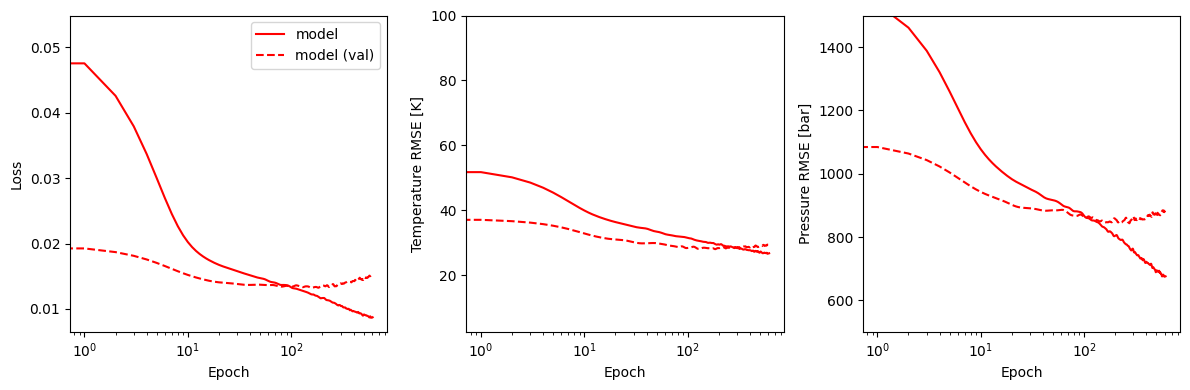

In [11]:
plot_training_curve("baseline.log", color="red", label="model", log_scale=True, ylims=[None, (2.5, 100), (500, 1500)])

14/14 [==============================] - 0s 1ms/step


(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='True pressure [bar]', ylabel='Predicted pressure [bar]'>,
        <Axes: xlabel='True temperature [°C]', ylabel='Predicted temperature [°C]'>],
       dtype=object))

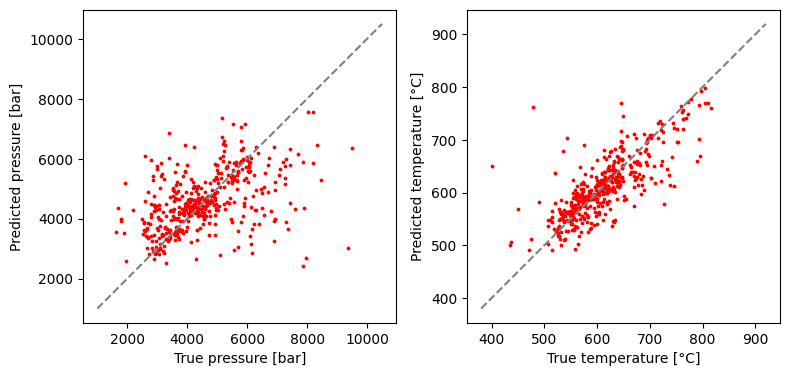

In [12]:
y_true = pt_val
y_pred = inv_scaling_pt(model.predict(data_val))

color = "red"

prediction_vs_truth(y_true, y_pred, color)
